### Import

In [1]:
import duckdb
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from google.cloud import storage
import re

## Positions

In [2]:
def duck_to_pandas(database_path, query):
    """
    Conecta ao DuckDB, executa a consulta SQL fornecida e retorna os resultados como um DataFrame do pandas.

    Args:
    - database_path (str): O caminho para o arquivo do banco de dados DuckDB.
    - query (str): A consulta SQL a ser executada.

    Returns:
    - pd.DataFrame: DataFrame contendo os resultados da consulta SQL.
    """
    try:
        # Conectar ao banco de dados DuckDB
        con = duckdb.connect(database=database_path, read_only=False)

        # Executar a consulta SQL e carregar os resultados em um DataFrame do pandas
        df = con.execute(query).df()

        # Fechar a conexão
        con.close()

        return df
    except Exception as e:
        print(f"Erro ao executar a consulta: {e}")
        return None

In [3]:
database_path = '/home/marcelo-borges/Documentos/Projetos/SIAN/laboratory/telemetry-validation/db/telemetria.duckdb'
query = "SELECT * FROM positions_"
df_positions = duck_to_pandas(database_path, query)

### EDA

In [4]:
#Usar o datawrangler para visualizar os dados

In [5]:
df_positions.describe()

,Longitude,Latitude,DriverId,AssetId,PositionId,OdometerKilometres,AgeOfReadingSeconds,Pdop,Hdop,NumberOfSatellites,Heading,AltitudeMetres,SpeedKilometresPerHour,SpeedLimit
count,2.861310e+06,2.861310e+06,2.861310e+06,2.861310e+06,2.861310e+06,2.857860e+06,2.861310e+06,2861296.0,2.861310e+06,2.861310e+06,2.861310e+06,1090125.0,2.861310e+06,1.020353e+06
mean,-4.928310e+01,-1.669824e+01,5.043319e+17,1.505073e+18,3.304818e+18,6.697207e+05,4.202312e+02,0.0,1.810838e+00,1.195400e+01,1.751592e+02,0.0,1.895042e+01,5.305794e+01
std,3.620484e-02,6.314757e-02,8.266153e+17,8.714745e+15,1.260722e+16,5.387774e+05,1.033417e+04,0.0,4.339789e+00,4.620112e-01,1.036577e+02,0.0,1.409634e+01,1.060326e+01
min,-4.948704e+01,-2.352033e+01,-8.208205e+18,1.498924e+18,3.275198e+18,1.000000e-02,0.000000e+00,0.0,0.000000e+00,4.000000e+00,0.000000e+00,0.0,0.000000e+00,2.000000e+01
25%,-4.929878e+01,-1.671175e+01,-1.066474e+17,1.498925e+18,3.295412e+18,4.921563e+05,0.000000e+00,0.0,1.000000e+00,1.200000e+01,7.900000e+01,0.0,4.366000e+00,4.000000e+01
50%,-4.928387e+01,-1.668846e+01,-1.066474e+17,1.498925e+18,3.306043e+18,6.145204e+05,0.000000e+00,0.0,1.000000e+00,1.200000e+01,1.720000e+02,0.0,2.049000e+01,6.000000e+01
75%,-4.926364e+01,-1.667407e+01,1.491699e+18,1.514417e+18,3.315412e+18,9.128918e+05,2.000000e+00,0.0,1.000000e+00,1.200000e+01,2.580000e+02,0.0,2.959800e+01,6.000000e+01
max,-4.667695e+01,-1.658963e+01,9.135806e+18,1.547012e+18,3.324552e+18,4.050610e+06,1.144871e+06,0.0,2.500000e+01,1.200000e+01,3.590000e+02,0.0,1.103850e+02,1.100000e+02


In [6]:
df_positions.dtypes

Timestamp                  object
Longitude                 float64
Latitude                  float64
DriverId                    int64
AssetId                     int64
PositionId                  int64
IsAvl                        bool
Source                     object
OdometerKilometres        float64
AgeOfReadingSeconds         int64
Pdop                      float64
Hdop                        int64
NumberOfSatellites          int64
Heading                     int64
AltitudeMetres            float64
SpeedKilometresPerHour    float64
FormattedAddress           object
SpeedLimit                float64
dtype: object

In [7]:
df_positions.isna().sum()

Timestamp                       0
Longitude                       0
Latitude                        0
DriverId                        0
AssetId                         0
PositionId                      0
IsAvl                           0
Source                          0
OdometerKilometres           3450
AgeOfReadingSeconds             0
Pdop                           14
Hdop                            0
NumberOfSatellites              0
Heading                         0
AltitudeMetres            1771185
SpeedKilometresPerHour          0
FormattedAddress          1279752
SpeedLimit                1840957
dtype: int64

### Casting

In [8]:
# df_positions['Timestamp'] = pd.to_datetime(df_positions['Timestamp'])

### Persisting database in file duckdb

In [9]:
# con.execute("CREATE TABLE positions AS SELECT * FROM df_positions")
# con.close()

In [10]:
hdop_counts = df_positions['Hdop'].value_counts()
hdop_percentages = df_positions['Hdop'].value_counts(normalize=True) * 100
hdop_summary = pd.DataFrame({
    'Count': hdop_counts,
    'Percentage': hdop_percentages
})
hdop_summary.reset_index().sort_values(by='Hdop', ascending=True)

,Hdop,Count,Percentage
2,0,7576,0.264774
0,1,2754144,96.254653
3,2,1920,0.067102
4,3,438,0.015308
5,4,173,0.006046
6,5,101,0.003530
7,6,79,0.002761
8,7,48,0.001678
9,8,23,0.000804
10,9,20,0.000699


#### Tratando os dados nulos no campo de Formatted Address

In [11]:
# import googlemaps
# from dotenv import load_dotenv
# from concurrent.futures import ThreadPoolExecutor
# load_dotenv()

In [12]:
# api_key = os.getenv('GOOGLE_MAPS_API_KEY')
# gmaps = googlemaps.Client(key=api_key)

In [13]:
# def reverse_geocode(lat, lon):
#     try:
#         result = gmaps.reverse_geocode((lat, lon))
#         if result:
#             return result[0]['formatted_address']
#         else:
#             return None
#     except Exception as e:
#         return None

In [14]:
# def process_row(row):
    # return reverse_geocode(row['Latitude'], row['Longitude'])

In [15]:
# geo_address = df_positions[['Latitude', 'Longitude']].dropna().head(1000)

In [16]:
# with ThreadPoolExecutor(max_workers=10) as executor:
#     geo_address['Address'] = list(executor.map(lambda row: process_row(row), [row for _, row in geo_address.iterrows()]))

# print(geo_address)

Neste estudo utilizamos 2 API's paga (Google Maps) e Gratuita (Nominatim). A limitação da gratuíta, é que as requisições tenham intervalos de no minimo 1 segundo. A base que estamos trabalhando que está congelada possui mais de 2 milhões de linhas e o tempo previsto para atualizar todos os dados nulos no campo é por volta de 30 dias initerruptos. Na API da google, nós não temos esta limitação de requisição e além disto, conseguimos operar utilizar multithread, entretanto, no teste que fizemos executamos por volta de 14 mil requisições e o custo ficou em R$ 448,72, a média ficou por volta de R$0,03 por requisão, aplicando este valor em 50% dos registros que é a situação atual da base, gastaríamos R$32.051 para corrigir este problema. Indico cobrar da Mix uma solução, pois este dado é importante futuramente para criamos labels dos dados.

![Billing - Geocoding - GCP](../img/geocoding-gcp.png)



### Uso de memória

#### original

In [17]:
specific_date = '2024-04-08'
# filtered_df = df_positions[df_positions['Timestamp'].dt.date == pd.to_datetime(specific_date).date()]
df_original = df_positions[df_positions['Timestamp'].str.contains(specific_date)]


In [18]:
import builtins
memory_usage_bytes = df_original.memory_usage(deep=True)
memory_values = list(memory_usage_bytes)
total_memory_usage_bytes = builtins.sum(memory_values)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_bytes} bytes")
total_memory_usage_mb = total_memory_usage_bytes / (1024 ** 2)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_mb:.2f} MB")
total_memory_usage_gb = total_memory_usage_bytes / (1024 ** 3)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_gb:.2f} GB")

Memória total usada pelo DataFrame: 6808474 bytes
Memória total usada pelo DataFrame: 6.49 MB
Memória total usada pelo DataFrame: 0.01 GB


#### sugerido

1. Trucagem nas casas decimais
2. ~~Retirada das colunas ['Pdop','NumberOfSatellites','FormattedAddress','AltitudeMetres']~~
3. Agrupamento dos campos calculados, principalmente devido a truncagem das geolocalizações

In [19]:
filtered_proposal_df = df_positions[df_positions['Timestamp'].str.contains(specific_date)]

In [20]:
filtered_proposal_df.dtypes

Timestamp                  object
Longitude                 float64
Latitude                  float64
DriverId                    int64
AssetId                     int64
PositionId                  int64
IsAvl                        bool
Source                     object
OdometerKilometres        float64
AgeOfReadingSeconds         int64
Pdop                      float64
Hdop                        int64
NumberOfSatellites          int64
Heading                     int64
AltitudeMetres            float64
SpeedKilometresPerHour    float64
FormattedAddress           object
SpeedLimit                float64
dtype: object

In [21]:
# Truncagem das casas decimais (por exemplo, 5 casas decimais para latitude e longitude)
filtered_proposal_df['Latitude'] = filtered_proposal_df['Latitude'].round(6)
filtered_proposal_df['Longitude'] = filtered_proposal_df['Longitude'].round(6)

/tmp/ipykernel_160654/3865845215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_proposal_df['Latitude'] = filtered_proposal_df['Latitude'].round(6)
/tmp/ipykernel_160654/3865845215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_proposal_df['Longitude'] = filtered_proposal_df['Longitude'].round(6)


In [24]:
columns_to_drop = ['Hdop','Pdop','NumberOfSatellites', 'FormattedAddress','AgeOfReadingSeconds']

In [25]:
filtered_proposal_df.drop(columns=columns_to_drop, inplace=True)

/tmp/ipykernel_160654/3225138080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_proposal_df.drop(columns=columns_to_drop, inplace=True)


In [26]:
# Foi decidido que não haverá mais a necessidade de agrupar os dados por latitude e longitude, pois a análise será feita em cima de todos os dados disponíveis.
# email enviado dia 26/07/2024.

# # Selecionar apenas colunas numéricas para o agrupamento
# numeric_columns = filtered_proposal_df.select_dtypes(include=['number']).columns.tolist()

# # Incluir Latitude e Longitude para agrupamento
# group_columns = ['Timestamp','IsAvl','Latitude', 'Longitude']
# numeric_columns = [col for col in numeric_columns if col not in group_columns]

# # Agrupar por latitude e longitude truncados e calcular a média das colunas numéricas
# filtered_proposal_df = filtered_proposal_df.groupby(group_columns)[numeric_columns].mean().reset_index()

In [28]:
import builtins
memory_usage_bytes = filtered_proposal_df.memory_usage(deep=True)
memory_values = list(memory_usage_bytes)
total_memory_usage_bytes = builtins.sum(memory_values)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_bytes} bytes")
total_memory_usage_mb = total_memory_usage_bytes / (1024 ** 2)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_mb:.2f} MB")
total_memory_usage_gb = total_memory_usage_bytes / (1024 ** 3)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_gb:.2f} GB")

Memória total usada pelo DataFrame: 5000086 bytes
Memória total usada pelo DataFrame: 4.77 MB
Memória total usada pelo DataFrame: 0.00 GB


#### Dados originais (geolocalizacao)

In [29]:
gdf = gpd.GeoDataFrame(df_original, geometry=gpd.points_from_xy(df_original.Longitude, df_original.Latitude))

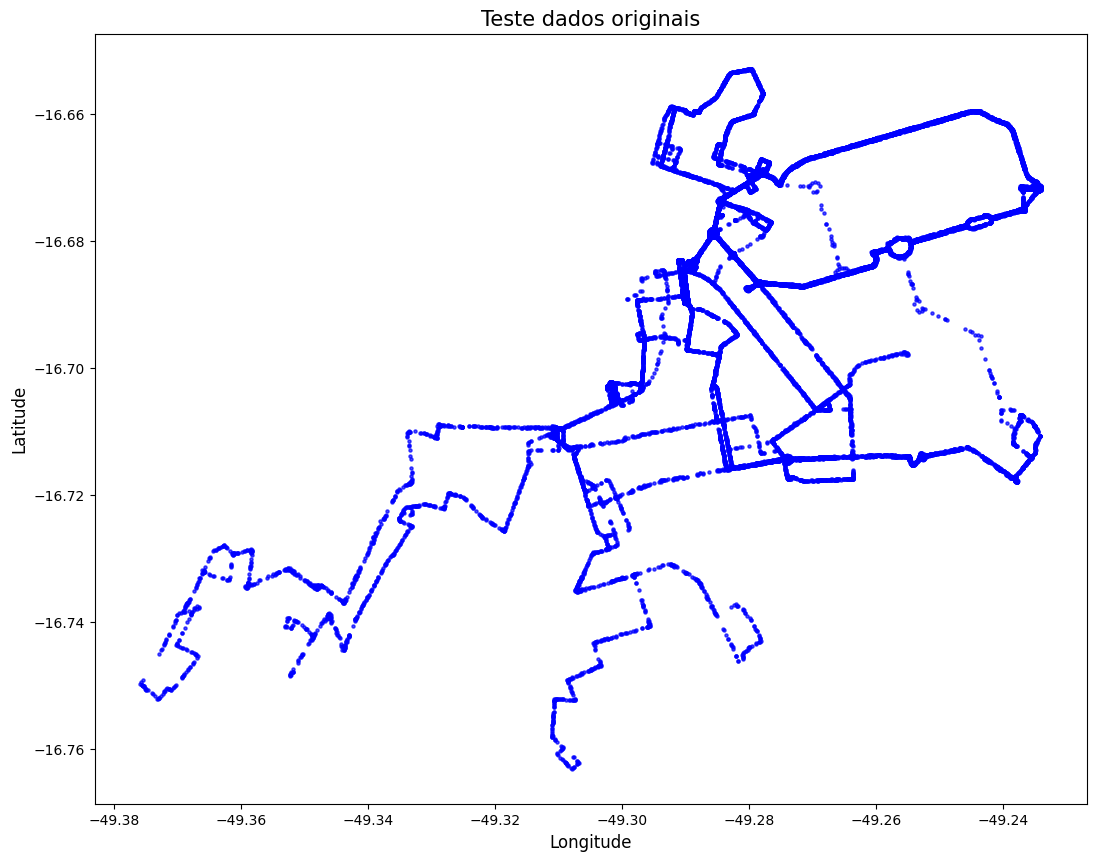

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plotar a linha de viagem
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, linestyle='-', alpha=0.7)

# Adicionar títulos e rótulos
ax.set_title('Teste dados originais', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()

plt.show()

#### Dados processados com sugestões

In [31]:
specific_date = '2024-04-08'

In [32]:
gdf = gpd.GeoDataFrame(filtered_proposal_df, geometry=gpd.points_from_xy(filtered_proposal_df.Longitude, filtered_proposal_df.Latitude))

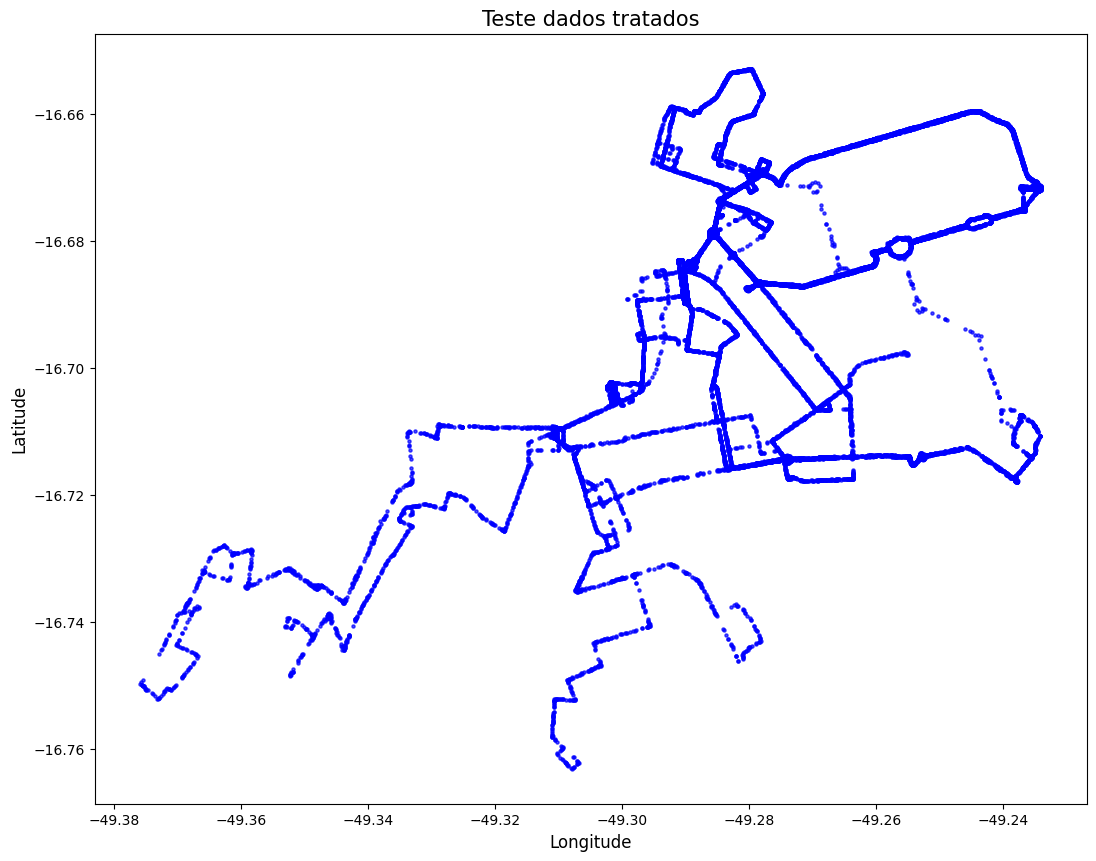

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plotar a linha de viagem
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, linestyle='-', alpha=0.7)

# Adicionar títulos e rótulos
ax.set_title('Teste dados tratados', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()

plt.show()

#### Extração de dados para analise do cliente

In [34]:
df_original.to_excel('position_original.xlsx', index=False)
filtered_proposal_df.to_excel('position_tratada.xlsx', index=False)

In [39]:
filtered_proposal_df.shape # Quantidade de linhas e colunas

(23800, 13)

In [38]:
filtered_proposal_df.isnull().sum() #Verificação de valores nulos

Timestamp                     0
Longitude                     0
Latitude                      0
DriverId                      0
AssetId                       0
PositionId                    0
IsAvl                         0
Source                        0
OdometerKilometres           20
Heading                       0
AltitudeMetres            14865
SpeedKilometresPerHour        0
SpeedLimit                20999
dtype: int64